In [1]:
import torch
import torch.nn.functional as F
from config import initialize
from dataset import CollateWrapper
from system import ImageTransform
import matplotlib.pyplot as plt
import torchvision

In [ ]:
# NOTE:
# sample_thanh: data/VNOnDB/word/train_word/20140603_0003_BCCTC_tg_0_0_3.png

In [2]:
device = 'cpu'
ckpt = torch.load('runs/18-05-2020_13-07-56_vnondb_tf_2en_2de_ff4096/weights/BEST.pt', map_location=device)
config = ckpt['config']

In [12]:
cnn = initialize(config['cnn'])
vocab = initialize(config['vocab'], add_blank=False)

model = initialize(config['model'], cnn, vocab)
model.load_state_dict(ckpt['model'])
model.eval();

image_transform = ImageTransform(augmentation=True,
                                 scale_height = config['dataset']['scale_height'],
                                 min_width = config['dataset']['min_width'])

dataset = initialize(config['dataset'], vocab=vocab,
                     csv=config['dataset']['train']['csv'],
                     image_folder=config['dataset']['train']['image_folder'],
                     image_transform=image_transform.test, subset=False)

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=2,
                                     collate_fn=lambda batch: CollateWrapper(batch))

iter_loader = iter(loader)



def cnn_hook(module, _inputs, outputs):
    global feature_width, feature_height, image_width, image_height
    global inputs
    inputs = _inputs[0]
    feature_height, feature_width = outputs.shape[-2], outputs.shape[-1]

def hook_fn(module, inputs, outputs):
    global weights
    # outputs: (context, weights)
    weights = outputs[1] # (B, T, S)

for name, module in model.named_modules():
    if name == 'decoder.layers.1.multihead_attn':
        module.register_forward_hook(hook_fn)
    elif name == 'cnn':
        module.register_forward_hook(cnn_hook)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


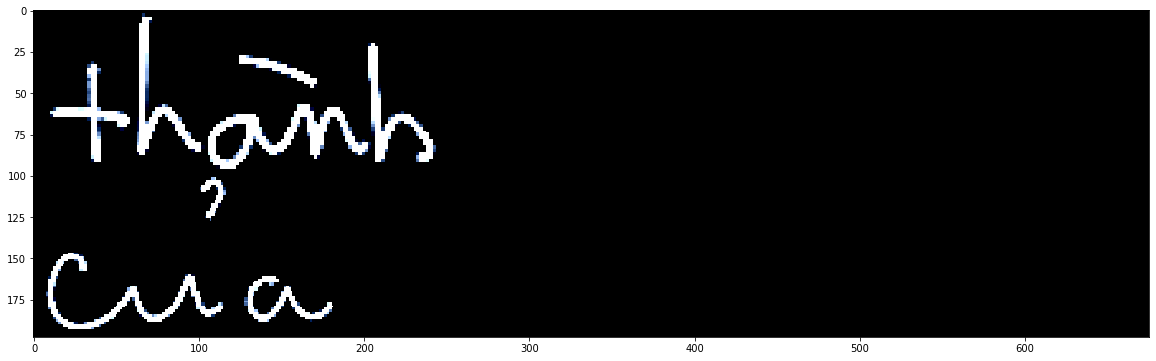

In [16]:
batch = next(iter_loader)

plt.figure(figsize=(20,15))
grid = torchvision.utils.make_grid(batch.images, nrow=1)
plt.imshow(grid.permute(1,2,0))

In [17]:
with torch.no_grad():
    outputs = model.greedy(batch.images)
    for output in outputs.cpu().tolist():
        output = list(map(vocab.int2char, output))
        output = vocab.process_label_invert(output)
        output = ' '.join(output)
        print(output)

t h à n h <end>
c ủ a <end> <end> <end>


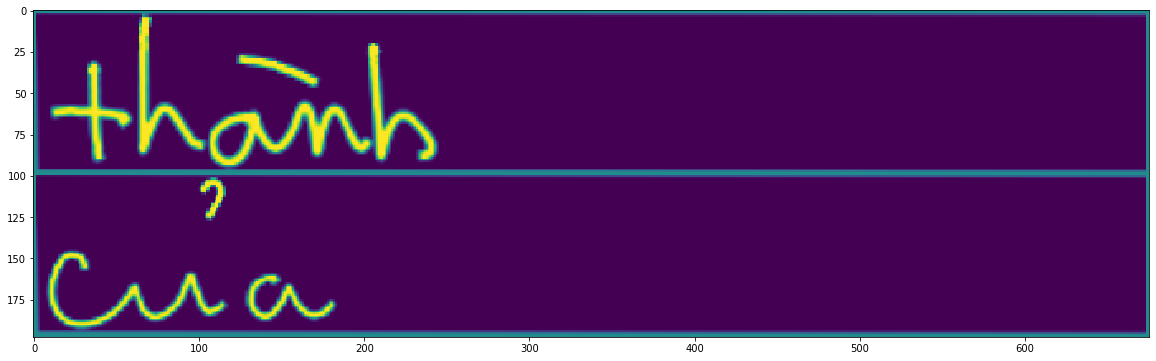

In [18]:
def visualize_stn():
    stn = model.stn(inputs).detach()
    plt.figure(figsize=(20,15))
    stn = torchvision.utils.make_grid(stn, nrow=1)[0]
    plt.imshow(stn)
    plt.show()
visualize_stn()

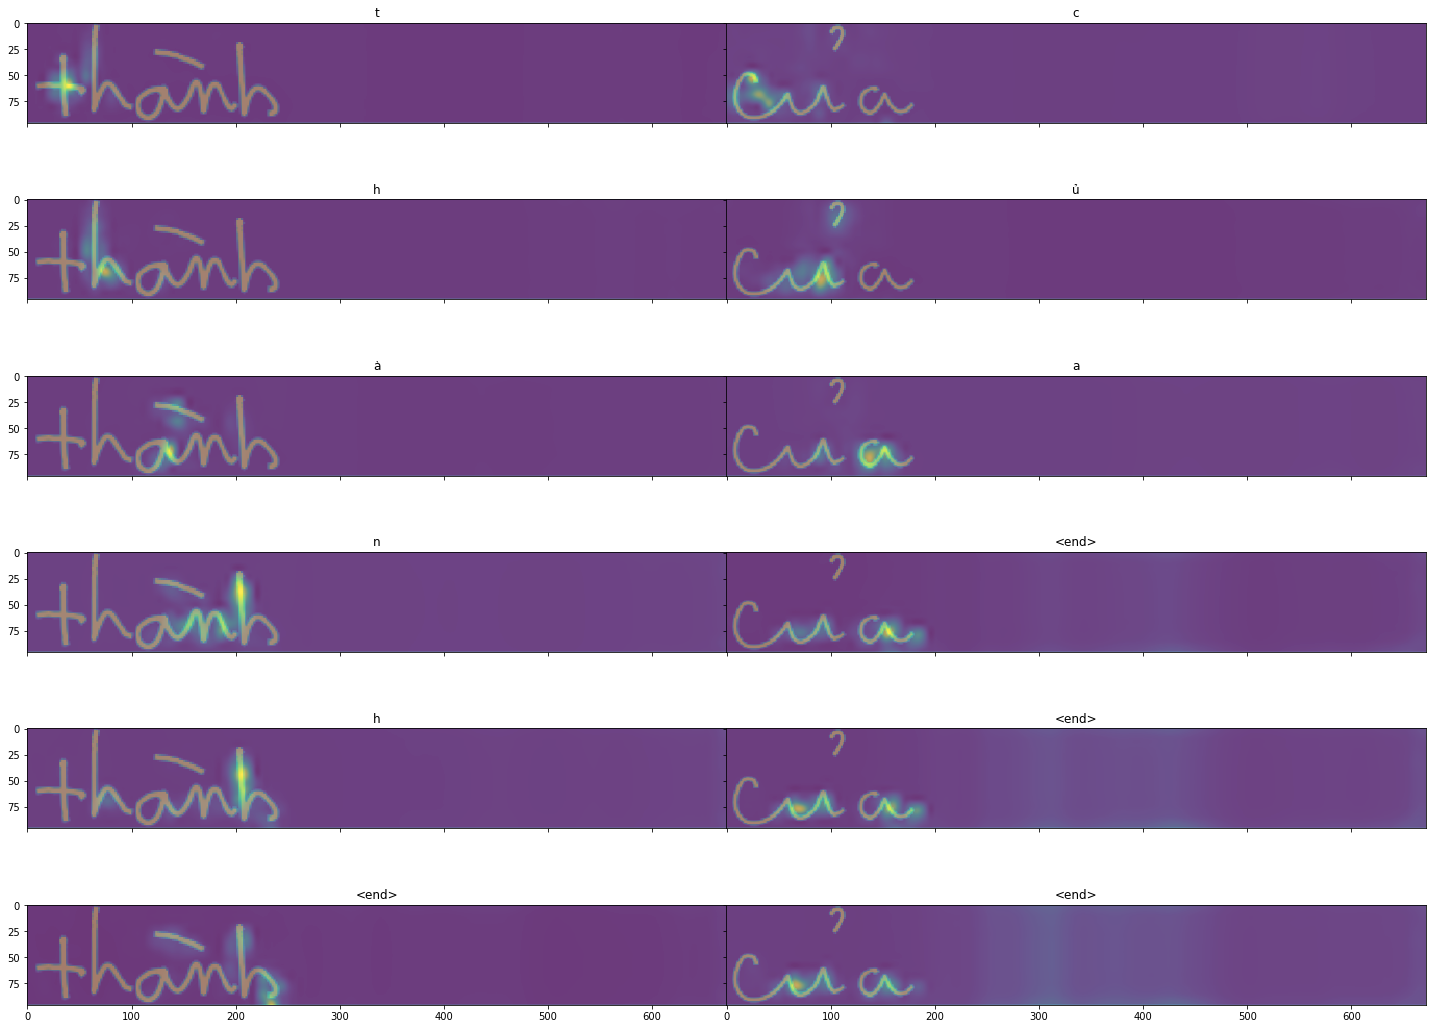

In [19]:
def visualize_weights():
    global image_height, image_width, weights
    alpha = 0.7
    B, T, S = weights.shape
    fig, axes = plt.subplots(T, B, figsize=(20, 15), sharex=True, sharey=True, squeeze=False)

    for i, sample in enumerate(weights):
        output = list(map(vocab.int2char, outputs[i]))
        output = vocab.process_label_invert(output)
        for j, weight in enumerate(sample):
            image_height, image_width = inputs[i, 0].shape[-2], inputs[i, 0].shape[-1]
            weight = weight.reshape(1, 1, feature_width, feature_height)
            weight = weight.transpose(-2, -1)
            weight = F.interpolate(weight, (image_height, image_width), mode='bicubic', align_corners=True) # 1,H,W
#             weight = torchvision.transforms.Resize((image_height, image_width))(weight)
            weight = weight.squeeze(0).squeeze(0) # H,W
    
            input = inputs[i, 0] # H,W
#             input = input.unsqueeze(0).unsqueeze(0) # H,W
#             input = F.interpolate(input, (feature_height, feature_width), mode='bicubic', align_corners=True) # 1,H,W
#             input = input.squeeze(0).squeeze(0)

            axes[j, i].set_title(output[j])
            axes[j, i].imshow(weight, cmap='viridis', alpha=alpha)
            axes[j, i].imshow(input, cmap='viridis', alpha=(1-alpha))
            
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
visualize_weights()

In [ ]:
plt.close()